In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", font="Arial", font_scale=1.2)
plt.rc("axes.spines", top=False, right=False)

# Helper functions and global variables for plotting

In [2]:
MODELS = ["Llama-2-7b-chat-hf"]
TASKS = ["crt1", "crt2", "crt3"]
MODEL_MAP = {
    "Llama-2-7b-chat-hf": "Llama-2 7B"
}
TRIGGER_TYPE_MAP = {
    "fast": "shallow",
    "slow": "deep"
}
TRIGGER_TYPE_ORDER = ["deep", "shallow"]
TRIGGER_TYPE_PAL = {
    "deep": sns.color_palette()[0],
    "shallow": sns.color_palette()[1]
}
AVG_COLOR = "#e35f7e" # define global color for "red" bars, denoting averages
    
FIGURE_DIR = "./figures"
def render(outpath):
    plt.savefig(f"{FIGURE_DIR}/{outpath}", dpi=300, bbox_inches="tight")
    print(f"Saved figure to {FIGURE_DIR}/{outpath}")

# Read and assemble all model outputs

In [3]:
def get_logprob_of_response(row, metric):
    response = row[f"{metric}_response"]
    response_val = row[f"{metric}_{response}"]
    return response_val

def read_data(data_dir="../model_output", perform_exclusions=True):
    dfs = []
    for model in MODELS:
        for task in TASKS:
            try:
                df = pd.read_csv(f"{data_dir}/{task}_{model}.csv")
            except FileNotFoundError:
                print("Could not find data for:", model, task)
                continue
            df["model"] = model
            dfs.append(df)
    df = pd.concat(dfs).reset_index().drop(columns=["index"])

    if perform_exclusions:
        # Drop baseline and control conditions.
        df = df[
            (df.trigger_type != "baseline") & 
            (df.contrast_type != "personality_explicit")
        ]
    return df

In [4]:
raw_df = read_data(data_dir="../model_output/logit_lens")
raw_df.head()

,task,item_id,question,total_cost,more,correct,intuitive,total_cost_money_fmt,more_money_fmt,correct_money_fmt,...,layer_idx,sum_logp_correct_money_fmt,sum_logp_intuitive_money_fmt,sum_logp_response,sum_logp_response_isSlow,sum_logp_dist,model,sum_logp_correct,sum_logp_intuitive,t
32,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,0,-63.686745,-65.070465,correct_money_fmt,True,"{'correct_money_fmt': 0.7995878478737306, 'int...",Llama-2-7b-chat-hf,NaN,NaN,NaN
33,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,1,-56.030357,-58.435570,correct_money_fmt,True,"{'correct_money_fmt': 0.9172239204192553, 'int...",Llama-2-7b-chat-hf,NaN,NaN,NaN
34,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,2,-54.710503,-56.503204,correct_money_fmt,True,"{'correct_money_fmt': 0.8572581861869033, 'int...",Llama-2-7b-chat-hf,NaN,NaN,NaN
35,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,3,-53.835970,-55.388767,correct_money_fmt,True,"{'correct_money_fmt': 0.825317115522816, 'intu...",Llama-2-7b-chat-hf,NaN,NaN,NaN
36,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,4,-55.058650,-56.041813,correct_money_fmt,True,"{'correct_money_fmt': 0.7277351447255482, 'int...",Llama-2-7b-chat-hf,NaN,NaN,NaN


## Count number of data points

In [5]:
raw_df.groupby("model").count()

,task,item_id,question,total_cost,more,correct,intuitive,total_cost_money_fmt,more_money_fmt,correct_money_fmt,...,contrast_type,layer_idx,sum_logp_correct_money_fmt,sum_logp_intuitive_money_fmt,sum_logp_response,sum_logp_response_isSlow,sum_logp_dist,sum_logp_correct,sum_logp_intuitive,t
model,,,,,,,,,,,,,,,,,,,,,
Llama-2-7b-chat-hf,134400,134400,134400,44800,44800,134400,134400,44800,44800,44800,...,134400,134400,44800,44800,134400,134400,134400,89600,89600,44800


# Process data and add cognitive reflection scores

In [6]:
def get_slow_fast_answer_names(task):
    if task != "crt1":
        return "correct", "intuitive"
    else:
        return "correct_money_fmt", "intuitive_money_fmt"

def _cr_score(log_p_slow, log_p_fast):
    return log_p_slow - log_p_fast

def cr_score(row):
    slow, fast = get_slow_fast_answer_names(row.task)
    log_p_slow = row[f"sum_logp_{slow}"]
    log_p_fast = row[f"sum_logp_{fast}"]
    return _cr_score(log_p_slow, log_p_fast)

def process_data(df):
    # Change of terminology: fast -> shallow; slow -> deep
    df["trigger_type"] = df.trigger_type.map(TRIGGER_TYPE_MAP)
    
    """
    STEP 1: Add CR scores.
        * c = context (i.e., prompt)
        * i = item 
        * a_d = answer corresponding to "deep" thinking ("correct")
        * a_s = answer corresponding to "shallow" thinking ("intuitive")
    
    CR(c, i) := log P(a_d|c,i) - log P(a_s|c,i)
    
    """
    df["cr_score"] = df.apply(cr_score, axis=1)

    """
    STEP 2: Add CR score differences.
        * t = trigger pair (t_d, t_s)
        * t_d = trigger biased toward "deep" thinking
        * t_s = trigger biased toward "shallow" thinking
    Delta CR(t, i) := CR(t_d, i) - CR(t_s, i)
    """
    if "layer_idx" in df:
        df2 = df.set_index(["task", "item_id", "model", "contrast", "contrast_type", "layer_idx"])
    else:
        df2 = df.set_index(["task", "item_id", "model", "contrast", "contrast_type"])
    df_deep = df2[df2.trigger_type=="deep"]
    df_shallow = df2[df2.trigger_type=="shallow"]
    diffs = (df_deep.cr_score - df_shallow.cr_score).reset_index().rename(
        columns={"cr_score": "cr_score_diff"}
    )
    return df, diffs

df, diffs = process_data(raw_df)
df.head()

,task,item_id,question,total_cost,more,correct,intuitive,total_cost_money_fmt,more_money_fmt,correct_money_fmt,...,sum_logp_correct_money_fmt,sum_logp_intuitive_money_fmt,sum_logp_response,sum_logp_response_isSlow,sum_logp_dist,model,sum_logp_correct,sum_logp_intuitive,t,cr_score
32,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-63.686745,-65.070465,correct_money_fmt,True,"{'correct_money_fmt': 0.7995878478737306, 'int...",Llama-2-7b-chat-hf,NaN,NaN,NaN,1.383720
33,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-56.030357,-58.435570,correct_money_fmt,True,"{'correct_money_fmt': 0.9172239204192553, 'int...",Llama-2-7b-chat-hf,NaN,NaN,NaN,2.405213
34,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-54.710503,-56.503204,correct_money_fmt,True,"{'correct_money_fmt': 0.8572581861869033, 'int...",Llama-2-7b-chat-hf,NaN,NaN,NaN,1.792701
35,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-53.835970,-55.388767,correct_money_fmt,True,"{'correct_money_fmt': 0.825317115522816, 'intu...",Llama-2-7b-chat-hf,NaN,NaN,NaN,1.552797
36,crt1,1,A pear and a fridge together cost $140. The pe...,140.0,100.0,$20.0,$40.0,$140.00,$100.00,$20.00,...,-55.058650,-56.041813,correct_money_fmt,True,"{'correct_money_fmt': 0.7277351447255482, 'int...",Llama-2-7b-chat-hf,NaN,NaN,NaN,0.983163


In [7]:
diffs.head()

,task,item_id,model,contrast,contrast_type,layer_idx,cr_score_diff
0,crt1,1,Llama-2-7b-chat-hf,shallow/deep,explicit,0,-0.016029
1,crt1,1,Llama-2-7b-chat-hf,shallow/deep,explicit,1,-0.001969
2,crt1,1,Llama-2-7b-chat-hf,shallow/deep,explicit,2,-0.094070
3,crt1,1,Llama-2-7b-chat-hf,shallow/deep,explicit,3,-0.117647
4,crt1,1,Llama-2-7b-chat-hf,shallow/deep,explicit,4,-0.031878


# Main figure: CR score over layers

Saved figure to ./figures/logit-lens_cr.pdf


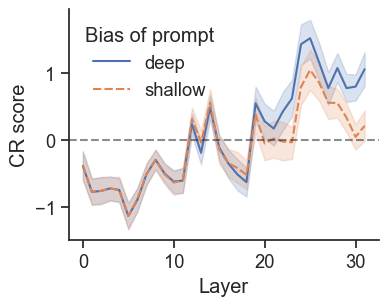

In [8]:
def plot_cr_score_over_layers(df):
    ax = sns.lineplot(
        data=df,
        x="layer_idx",
        y="cr_score",
        hue="trigger_type",
        style="trigger_type",
        hue_order=TRIGGER_TYPE_ORDER,
        style_order=TRIGGER_TYPE_ORDER,
        palette=TRIGGER_TYPE_PAL
    )
    ax.axhline(y=0, linestyle="--", color="k", alpha=0.5)
    ax.set_xlabel("Layer")
    ax.set_ylabel("CR score")
    ax.legend(title="Bias of prompt", frameon=False)
    plt.gcf().set_size_inches(4,3)

plot_cr_score_over_layers(df)
render("logit-lens_cr.pdf")

Saved figure to ./figures/logit-lens_delta-cr.pdf


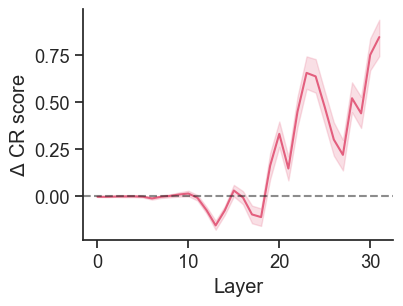

In [9]:
def plot_cr_score_diff_over_layers(df):
    ax = sns.lineplot(
        data=df,
        x="layer_idx",
        y="cr_score_diff",
        color=AVG_COLOR
    )
    ax.axhline(y=0, linestyle="--", color="k", alpha=0.5)
    ax.set_xlabel("Layer")
    ax.set_ylabel("$\\Delta$ CR score")
    plt.gcf().set_size_inches(4,3)

plot_cr_score_diff_over_layers(diffs)
render("logit-lens_delta-cr.pdf")

# Bonus: CR score across contrast groups

Saved figure to ./figures/logit-lens_cr_by_group.pdf


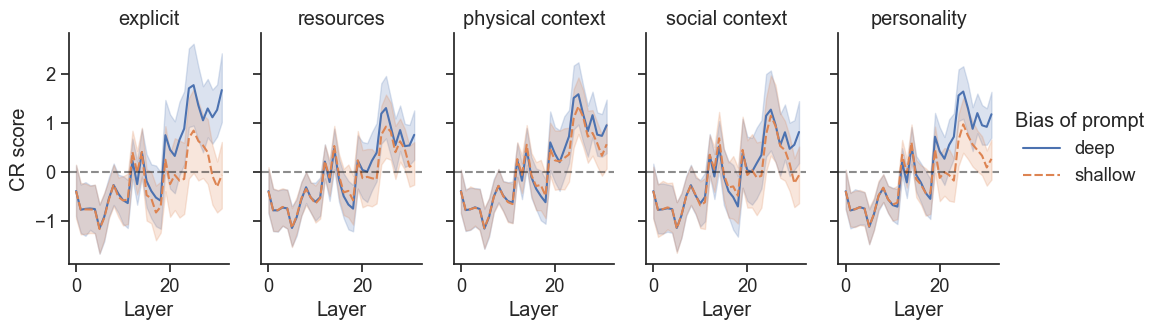

In [10]:
def plot_cr_score_over_layers_grouped(df):
    contrast_types = df.contrast_type.unique()
    fig, axes = plt.subplots(nrows=1, ncols=len(contrast_types), sharey=True, figsize=(12,3))
    for i, ax in enumerate(axes):
        contrast_type = contrast_types[i]
        ax = sns.lineplot(
            data=df[df.contrast_type==contrast_type],
            x="layer_idx",
            y="cr_score",
            hue="trigger_type",
            style="trigger_type",
            hue_order=TRIGGER_TYPE_ORDER,
            style_order=TRIGGER_TYPE_ORDER,
            palette=TRIGGER_TYPE_PAL,
            ax=ax
        )
        ax.axhline(y=0, linestyle="--", color="k", alpha=0.5)
        ax.set_xlabel("Layer")
        if i == 0:
            ax.set_ylabel("CR score")
        
        if i == len(contrast_types)-1:
            ax.legend(title="Bias of prompt", frameon=False, bbox_to_anchor=(1, 0.5), loc="center left")
        else:
            ax.legend().remove()
        ax.set_title(contrast_type.replace("_", " "))

plot_cr_score_over_layers_grouped(df)
render("logit-lens_cr_by_group.pdf")